In [1]:
# Import required packages
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50, VGG16, InceptionV3
from keras.applications.vgg16 import preprocess_input, decode_predictions
# from utils import make_parallel
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from keras.utils import to_categorical
from tqdm import tqdm
%matplotlib inline

Using TensorFlow backend.


## Method 1: Apply pre-trained model on training data directly

#### Steps 

- Load image：cv2.imread
- Modify size：cv2.resize, the input image size of VGG16 is 224 * 224
- Modify dimension：np.expand_dims, the input of VGG16 is 4 channels
- Preprocess：preprocess_input，VGG16 uses mean substraction
- Predict：model.predict
- Decode result：decode_predictions, decode the results into a list of tuples (class, description, probability). E.g. (u'n02504013', u'Indian_elephant', 0.82658225)

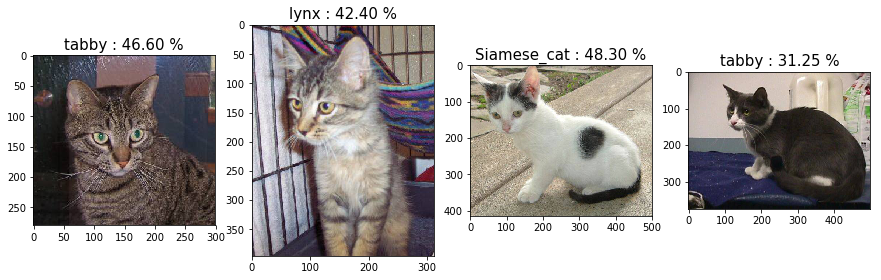

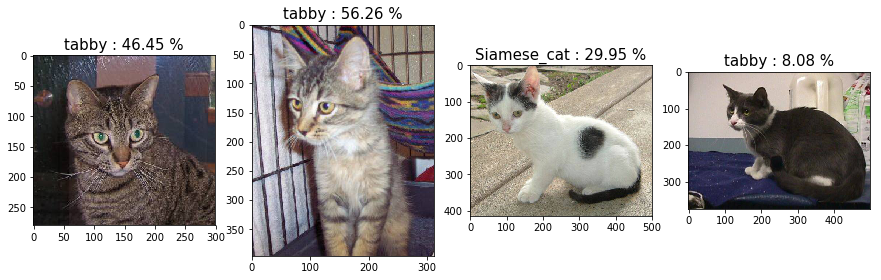

In [18]:
# First try - VGG16
model1 = VGG16(weights='imagenet', include_top=True)
#path = '/home/ubuntu/udacity_machine_learning/cats-vs-dogs'

def inference(files, preprocess=True):
    plt.figure(figsize=(15, 7))
    for i in range(len(files)):
        plt.subplot(1, len(files), i+1)
        img = cv2.imread(files[i])
        img = img[:, :, ::-1]
        x = cv2.resize(img, dsize=(224, 224))
        x = np.expand_dims(x, axis=0)
        x = x.astype(np.float64)
        if preprocess:
            x = preprocess_input(x)
        y_pred = model1.predict(x)
        _, label, prob = decode_predictions(y_pred, top=1)[0][0]
        plt.imshow(img, cmap='gray')
        plt.title('%s : %.2f %%' % (label, prob * 100), size=15)
    plt.show()

inference(['./train/cat/cat.1.jpg', './train/cat/cat.2.jpg', './train/cat/cat.3.jpg', './train/cat/cat.4.jpg'], False)
inference(['./train/cat/cat.1.jpg', './train/cat/cat.2.jpg', './train/cat/cat.3.jpg', './train/cat/cat.4.jpg'])



**Observation**

- Although the model hasn't seen the images in the training set, it does have seen the image type "cat" from imagenet. So the model can provide fairly accurate prediction results.
- The result of preprocessing may not be always helpful. The probability of 1st image is down from 65% to 15% while that of 3rd image is up from 71% to 99%.

## Method 2: Apply pre-trained model on training data but with new classifer

**Two solutions**
- Solution 1: Load the entire pre-trained model plus weights, replace with new classifier.
- Solution 2: Create the model with the same structure of the pre-trained model and only load the pre-trained weights, replace with new classifier.

### 2.0 Data Preparation

#### Steps
- Read input：cv2.imread
- Change image size：cv2.resize
- Define image type：cat = 0, dog = 1
- Shuffle the sequence of images and classification：shuffle
- Split training set into training and validation sets：train_test_split

In [3]:
shape = 224 # VGG16 input size = 224*224
label = np.array([0] * 12500 + [1] * 12500)
data = np.zeros((25000, shape, shape, 3), dtype=np.uint8)

for i in tqdm(range(12500)):
    img = cv2.imread('./train/cat.%s.jpg' % str(i))
    img = img[:, :, ::-1]
    data[i] = cv2.resize(img, (shape, shape))
    
for i in tqdm(range(12500)):
    img = cv2.imread('./train/dog.%s.jpg' % str(i))
    img = img[:, :, ::-1]
    data[i + 12500] = cv2.resize(img, (shape, shape))
    
print('Training Data Size = %.2f GB' % (sys.getsizeof(data)/1024**3))

100%|██████████| 12500/12500 [01:54<00:00, 109.38it/s]

Training Data Size = 3.00 GB


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.2, random_state=42)

In [6]:
test = np.zeros((12500, shape, shape, 3), dtype=np.uint8)
for i in tqdm(range(12500)):
    img = cv2.imread('./test/%s.jpg' % str(i + 1))
    img = img[:, :, ::-1]
    test[i] = cv2.resize(img, (shape, shape))
print('Testing Data Size = %.2f GB' % (sys.getsizeof(test)/1024**3))

100%|██████████| 12500/12500 [01:30<00:00, 138.42it/s]

Testing Data Size = 1.00 GB


### 2.1 Load the entire pre-trained model plus weights, replace with new classifier.

#### Steps
- Load pre-trained model and weight, excluding the original classifier
- Lock the layers of the pre-trained model to prevent the change during the training process: layers.trainable = False
- Add the new classifier to the end of the model. Choose sigmoid or softmax based on the number of types that need to classify
- Compire the model.Choose binary_crossentropy or categorical_crossentropy based on the number of types that need to classify
- Check the number of trainable weights: create function get_param_count() to count unlocked parameters
- Train the model
  - Use small batch size so that we can get high precision even with a few epochs
  - No need to use too many epochs, 5 ~ 10 is enough. Because the number of trainable parameters is small (~500), it can achieve the optimal without too many epochs.

**First I use VGG16 (22 layers) model for transfer learning.**

In [7]:
from keras import backend as K

def get_params_count(model):
    trainable = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    non_trainable = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))
    return trainable, non_trainable

In [8]:
base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='avg')

for layers in base_model.layers:
    layers.trainable = False

y = Dropout(0.5)(base_model.output)
y = Dense(1, activation='sigmoid')(y)

model1 = Model(inputs=base_model.input, outputs=y)
model1.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model1.summary()
print('Model has %d layers.' % len(model1.layers))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
model1.fit(x=X_train, y=y_train, batch_size=16, epochs=5, validation_data=(X_val, y_val), shuffle=True)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 509s - loss: 1.1711 - acc: 0.8045 - val_loss: 0.1745 - val_acc: 0.9540
Epoch 2/5
20000/20000 [==============================] - 484s - loss: 0.3822 - acc: 0.9157 - val_loss: 0.1281 - val_acc: 0.9636
Epoch 3/5
20000/20000 [==============================] - 483s - loss: 0.2848 - acc: 0.9304 - val_loss: 0.1187 - val_acc: 0.9658
Epoch 4/5
20000/20000 [==============================] - 484s - loss: 0.2421 - acc: 0.9394 - val_loss: 0.1072 - val_acc: 0.9662
Epoch 5/5
20000/20000 [==============================] - 484s - loss: 0.2120 - acc: 0.9415 - val_loss: 0.0973 - val_acc: 0.9680


**Now let's try ResNet50 model (178 layers). **

In [10]:
base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='avg')

for layers in base_model.layers:
    layers.trainable = False

y = Dropout(0.25)(base_model.output)
y = Dense(1, activation='sigmoid')(y)

model2 = Model(inputs=base_model.input, outputs=y)
model2.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model2.summary()
print('Model has %d layers.' % len(model2.layers))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [11]:
model2.fit(x=X_train, y=y_train, batch_size=16, epochs=5, validation_data=(X_val, y_val), shuffle=True)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 297s - loss: 0.1764 - acc: 0.9321 - val_loss: 0.0751 - val_acc: 0.9748
Epoch 2/5
20000/20000 [==============================] - 296s - loss: 0.1040 - acc: 0.9605 - val_loss: 0.0639 - val_acc: 0.9766
Epoch 3/5
20000/20000 [==============================] - 296s - loss: 0.0979 - acc: 0.9624 - val_loss: 0.0603 - val_acc: 0.9770
Epoch 4/5
20000/20000 [==============================] - 296s - loss: 0.0926 - acc: 0.9644 - val_loss: 0.0574 - val_acc: 0.9776
Epoch 5/5
20000/20000 [==============================] - 296s - loss: 0.0868 - acc: 0.9657 - val_loss: 0.0566 - val_acc: 0.9772


### 2.2 Create the model with the same structure of the pre-trained model and only load the pre-trained weights, replace with new classifier

- It's much complicated than solution 1 as I have to create the model with the same structure by hand.
- It requires the model I create is the same as the pre-trained model (the size of all the weight matrixes should be the same). Otherwise, it will throw the error when loading the weights. The advantage of this solution is I can change the input size, hyper-paramters freely. For some dataset with small image size (e.g. CIRAR10), I have to either enlarge the image size or use solution 2 to modify the input size. 

In [12]:
x = Input(shape=(32, 32, 3))
y = x
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = GlobalAveragePooling2D()(y)
# y = Dropout(0.5)(y)
# y = Dense(10, activation='softmax')(y)

modelx = Model(inputs=x, outputs=y)

In [14]:
modelx.load_weights('/home/ubuntu/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
modelx.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [15]:
modelx.layers

In [16]:
[weights, bias] = modelx.layers[1].get_weights()
print(weights.shape)
print(bias.shape)

(3, 3, 3, 64)
(64,)


In [17]:
weights[:, :, :, 0]

array([[[ 0.42947057,  0.55037946,  0.4800154 ],
        [ 0.373467  ,  0.44007453,  0.4085474 ],
        [-0.06136011, -0.08138704, -0.06514555]],

       [[ 0.27476987,  0.34573907,  0.31047726],
        [ 0.03868078,  0.04063221,  0.05020237],
        [-0.36722335, -0.45350131, -0.40338343]],

       [[-0.05746817, -0.05863491, -0.05087169],
        [-0.26224968, -0.33066967, -0.28522751],
        [-0.35009676, -0.4850302 , -0.41851634]]], dtype=float32)

In [18]:
bias[0]

0.73429835

## Method 3: Apply pre-trained model on training data with new classifer and fine tune the last several layers

#### Steps
- Here I use the model2 created above. 
- Unblock the last several layers and train them.
- Since several layers form a combination (e.g. conv + batchNorm + acitvation), we'd better block/unblock the combination.
- Unblock the layers from high (output) to low (input). Train 5 epochs when unblocking on part. Then check if the loss and accuracy have improved. If the answer is yes, then we can continue training. Otherwise, we can unblock more layers until the training result has improvement.

In [19]:
model2.layers[-37:]

In [20]:
for layers in model2.layers[-35:]:
    layers.trainable = True
    
print('Trainable = %d, Non-Trainable = %d' % (get_params_count(model2)))

Trainable = 14453249, Non-Trainable = 9136512


In [21]:
model2.fit(x=X_train, y=y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 294s - loss: 0.0860 - acc: 0.9668 - val_loss: 0.0604 - val_acc: 0.9756
Epoch 2/10
20000/20000 [==============================] - 295s - loss: 0.0870 - acc: 0.9647 - val_loss: 0.0583 - val_acc: 0.9800
Epoch 3/10
20000/20000 [==============================] - 295s - loss: 0.0795 - acc: 0.9698 - val_loss: 0.0535 - val_acc: 0.9788
Epoch 4/10
20000/20000 [==============================] - 295s - loss: 0.0830 - acc: 0.9667 - val_loss: 0.0519 - val_acc: 0.9796
Epoch 5/10
20000/20000 [==============================] - 295s - loss: 0.0841 - acc: 0.9675 - val_loss: 0.0520 - val_acc: 0.9810
Epoch 6/10
20000/20000 [==============================] - 295s - loss: 0.0796 - acc: 0.9687 - val_loss: 0.0518 - val_acc: 0.9788
Epoch 7/10
20000/20000 [==============================] - 295s - loss: 0.0799 - acc: 0.9689 - val_loss: 0.0510 - val_acc: 0.9806
Epoch 8/10
20000/20000 [========================

In [22]:
model2.save('ResNet_Finetune_last3_epoch5.h5')

**Observation**

Even I unblock the last 35 layers, the improvement from fine-tune is still not obvious.

## Method 4: Multiple Model Integration

#### Steps

- Calculate feature vectors: calculate the output value of the entire training set from each model (excluding classifier part).
- Merge feature vectors: Merge the feature vectors from multiple models.
- Train the classifier
- Predict

### 4.1 Calculate feature vectors - Generator method

- Define file based generator (file_from_dictionary) and then use generator prediction function (predict_generator) to calculate feature vectors
- It reads files in batch from hard disk thus the speed is slow

In [ ]:
import h5py
def export_gap(MODEL, image_size, preprocess=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if preprocess:
        x = Lambda(preprocess)(x)
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    y = GlobalAveragePooling2D()(base_model.output)
    model = Model(base_model.input, y) 
    
    # Not for image enhancement, only for generator
    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("train", image_size, shuffle=False, batch_size=16, 
                                              classes=['cat', 'dog'])
    test_generator = gen.flow_from_directory("test", image_size, shuffle=False, batch_size=16, 
                                             class_mode=None)

    train = model.predict_generator(train_generator, train_generator.samples)
    test = model.predict_generator(test_generator, test_generator.samples)
    with h5py.File("gap_%s.h5" % MODEL.__name__, 'w') as f:
        f.create_dataset("train", data=train)
        f.create_dataset("test", data=test)
        f.create_dataset("label", data=train_generator.classes)
        
export_gap(VGG16, (224, 224))

### 4.2 Calculate feature vectors - Memory method

- Since I have already read the training and test datasets into memory, I can use model.predict() to get feature vectors directly.
- This is a faster way to get feature vectors. Average speed is 2 mins/per training + test feature vectors.

In [ ]:
import h5py
from keras.applications import inception_v3, xception, VGG19, Xception
from keras.layers import Lambda

def export_gap(MODEL, preprocess=None):
    x = Input((224, 224, 3))
    if preprocess:
        x = Lambda(preprocess)(x)
    model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')

    train_gap = model.predict(data, batch_size=128)
    test_gap = model.predict(test, batch_size=128)
    
    with h5py.File("gap_%s.h5" % MODEL.__name__, 'w') as f:
        f.create_dataset('train', data=train_gap)
        f.create_dataset('test', data=test_gap)

In [ ]:
export_gap(InceptionV3, preprocess=inception_v3.preprocess_input)
export_gap(Xception, preprocess=xception.preprocess_input)
export_gap(VGG16)
export_gap(VGG19)
export_gap(ResNet50)

### Integrate feature vectors from different models

- Use np.concatenate to integrate vectors on specific dimension.
- Feed all feature vectors to the classifier which uses gradient descent to set weights automatically.

In [ ]:
train = []
test = []
for gapfile in ['gap_InceptionV3.h5', 'gap_ResNet50.h5', 'gap_Xception.h5']:
    with h5py.File(gapfile, 'r') as f:
        train.append(np.array(f['train']))
        test.append(np.array(f['test']))
        
print('Feature Vector Shape for Model #0:', train[0].shape)

In [ ]:
X_train = np.concatenate(train, axis=1)
X_test = np.concatenate(test, axis=1)
print('Feature Vector Shape after Merging all 3 models:', X_train.shape)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, label, shuffle=True, test_size=0.2, random_state=42)

### 4.4 Create Model (Classifier)

- We just need to define a simple classifier to classify the feature vectors. The output is 0(cat) or 1(dog).
- The input of this model is the merged output of above 3 feature vectors. So the input size is (None, 2048 * 3).

In [ ]:
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.25)(x)
y = Dense(1, activation='sigmoid')(x)

model_fusion = Model(inputs=inputs, outputs=y, name='Fusion')
model_fusion.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model_fusion.summary()

### Train the Model

- The total number of parameters of the model is about 6000 and the structure is very simple. The training time is very short.

In [ ]:
model_fusion.fit(x=X_train, y=y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val))

### Predict the test set and upload result to Kaggle

- The judgment standard is LogLoss.
- Kaggle's scoring system will adjust the probability between 10^-15 and 1 - 10^-15)
- We change the output from 0/1 to 0.005/0.995 when the output is close to 0 or 1.


In [ ]:
y_pred = model_fusion.predict(X_test)
y_pred = y_pred.clip(min=0.005, max=0.995)

In [ ]:
y_pred.shape, y_pred[0]

In [ ]:
with open('test.csv', 'w') as f:
    f.writelines('id,label\n')
    for i in range(12500):
        f.writelines(str(i+1) + ',' + str(y_pred[i][0]) + '\n')